In [1]:
# Importing libraries required for data manipulation
import pandas as pd
import numpy as np

# Importing machine learning tools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Importing visualization libraries
import matplotlib.pyplot as plt

In [4]:
# Importing required library for data handling
import pandas as pd

# Defining the realtime runtime dataset path
DATA_PATH = "/content/household_power_clean file 2026.csv"

# Loading the dataset without datetime parsing initially
df = pd.read_csv(DATA_PATH)

# Creating a combined datetime column from Date and Time
df["DateTime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)

# Setting DateTime as the index
df = df.set_index("DateTime")

# Dropping original Date and Time columns
df = df.drop(columns=["Date", "Time"])

# Displaying dataset structure to verify successful loading
df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, NaT to NaT
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Global_active_power    float64
 2   Global_reactive_power  float64
 3   Voltage                float64
 4   Global_intensity       float64
 5   Sub_metering_1         float64
 6   Sub_metering_2         float64
 7   Sub_metering_3         float64
 8   Datetime               object 
 9   gap_monthly            float64
 10  grp_monthly            float64
 11  v_monthly              float64
 12  gi_monthly             float64
dtypes: float64(11), int64(1), object(1)
memory usage: 218.9+ MB


In [5]:
print(df.columns)



Index(['Unnamed: 0', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Datetime', 'gap_monthly', 'grp_monthly', 'v_monthly',
       'gi_monthly'],
      dtype='object')


In [6]:
# Selecting the prediction target
target = "Global_active_power"

# Creating lag features to simulate streaming data behavior
df["lag_1"] = df[target].shift(1)
df["lag_2"] = df[target].shift(2)
df["lag_24"] = df[target].shift(24)

# Removing rows with missing lag values
df_model = df.dropna()



In [7]:
# Performing a time-based split to preserve temporal order
split_index = int(len(df_model) * 0.8)

train = df_model.iloc[:split_index]
test = df_model.iloc[split_index:]

X_train = train[["lag_1", "lag_2", "lag_24"]]
y_train = train[target]

X_test = test[["lag_1", "lag_2", "lag_24"]]
y_test = test[target]


In [8]:
# Training a baseline linear regression model
model_1 = LinearRegression()
model_1.fit(X_train, y_train)

# Generating predictions on streaming test data
y_pred_1 = model_1.predict(X_test)


In [9]:
# Evaluating model performance using error metrics
mae_1 = mean_absolute_error(y_test, y_pred_1)
mse_1 = mean_squared_error(y_test, y_pred_1)
rmse_1 = np.sqrt(mse_1)

mae_1, rmse_1


(0.08435445272247184, np.float64(0.21938219143962354))

In [10]:
# Training a simplified model using fewer lag features
X_train_simple = train[["lag_1"]]
X_test_simple = test[["lag_1"]]

model_2 = LinearRegression()
model_2.fit(X_train_simple, y_train)

# Generating predictions
y_pred_2 = model_2.predict(X_test_simple)

# Evaluating simplified model
mae_2 = mean_absolute_error(y_test, y_pred_2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))

mae_2, rmse_2


(0.08328154975441172, np.float64(0.21983906561735048))

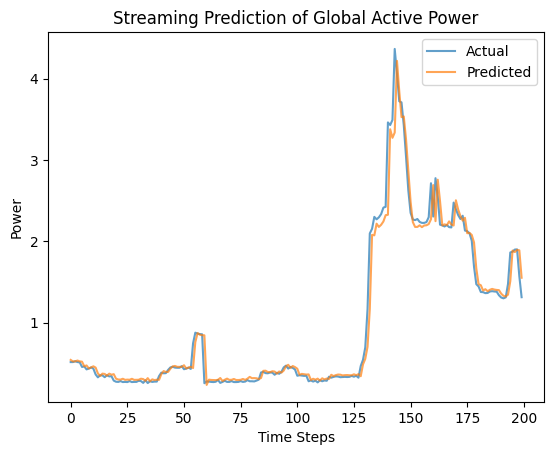

In [11]:
# Visualizing true vs predicted values for streaming data
plt.plot(y_test.values[:200], label="Actual", alpha=0.7)
plt.plot(y_pred_1[:200], label="Predicted", alpha=0.7)

plt.legend()
plt.title("Streaming Prediction of Global Active Power")
plt.xlabel("Time Steps")
plt.ylabel("Power")
plt.show()


In [15]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred_1.shape)

print("Any NaNs in y_test?", y_test.isna().any())
print("Any NaNs in y_pred?", np.isnan(y_pred_1).any())


y_test shape: (409851,)
y_pred shape: (409851,)
Any NaNs in y_test? False
Any NaNs in y_pred? False


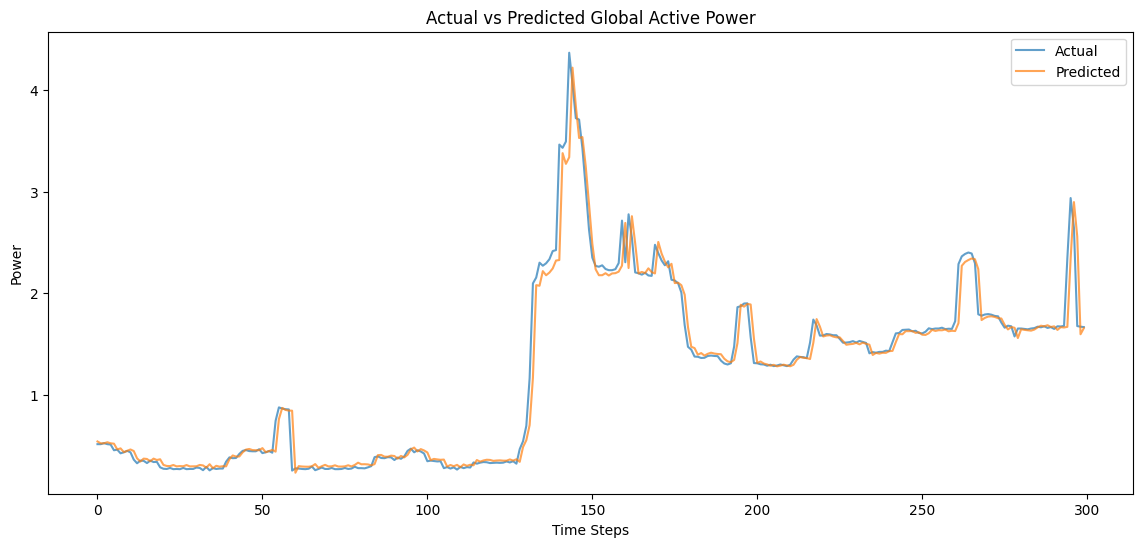

In [16]:
# Defining safe plot length
plot_len = min(300, len(y_test))

# Plotting actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(y_test.iloc[:plot_len].values, label="Actual", alpha=0.7)
plt.plot(y_pred_1[:plot_len], label="Predicted", alpha=0.7)

plt.legend()
plt.title("Actual vs Predicted Global Active Power")
plt.xlabel("Time Steps")
plt.ylabel("Power")
plt.show()


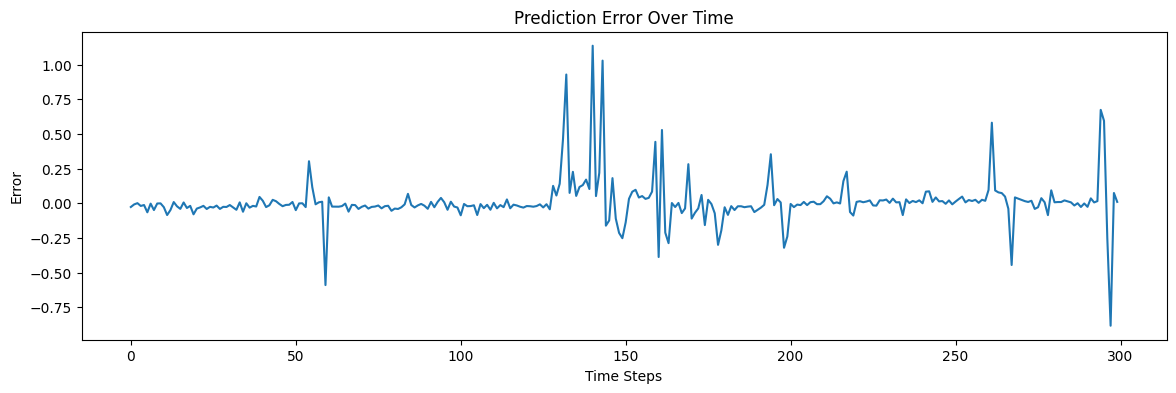

In [17]:
# Computing prediction errors safely
errors = y_test.values - y_pred_1

# Plotting error values
plt.figure(figsize=(14,4))
plt.plot(errors[:plot_len])

plt.title("Prediction Error Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Error")
plt.show()


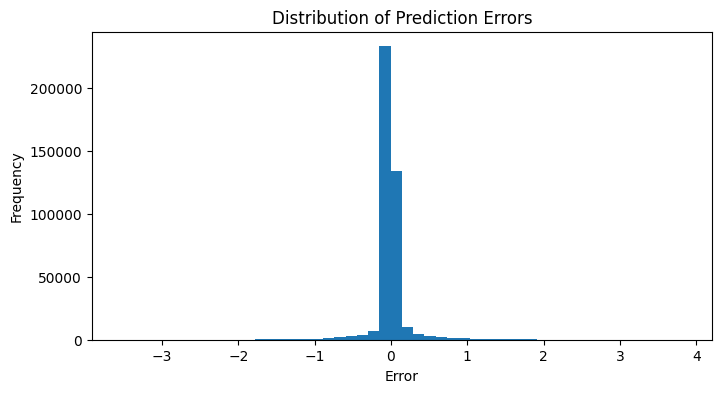

In [18]:
# Plotting residual distribution
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50)

plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [20]:
# Displaying learned model coefficients
coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model_1.coef_
})

coefficients


,Feature,Coefficient
0,lag_1,1.013904
1,lag_2,-0.070156
2,lag_24,0.032079


In [21]:
# Creating naive baseline predictions
y_naive = X_test["lag_1"].values

# Evaluating naive baseline
mae_naive = mean_absolute_error(y_test, y_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))

mae_naive, rmse_naive


(0.07191456407328516, np.float64(0.22151170672139278))

In [22]:
# Creating naive baseline predictions
y_naive = X_test["lag_1"].values

# Evaluating naive baseline
mae_naive = mean_absolute_error(y_test, y_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))

mae_naive, rmse_naive

(0.07191456407328516, np.float64(0.22151170672139278))

In [23]:
results = pd.DataFrame({
    "Model": ["Naive (lag-1)", "Linear Regression"],
    "MAE": [mae_naive, mae_1],
    "RMSE": [rmse_naive, rmse_1]
})

results


,Model,MAE,RMSE
0,Naive (lag-1),0.071915,0.221512
1,Linear Regression,0.084354,0.219382


### Q: Why is linear regression well suited for IoT and edge-based applications?

**A:**  
Linear regression is being used because it is computationally lightweight, fast to train, and efficient
to execute. These properties make it well suited for IoT and edge environments where hardware resources,
power consumption, and latency are constrained. While more complex models may achieve higher accuracy,
linear regression provides a practical balance between performance and efficiency for real-time
streaming data.


### Q: How does changing the number of lag features affect model performance?

**A:**  
Increasing the number of lag features is providing additional historical context to the model, which
generally improves prediction accuracy by capturing temporal dependencies. However, adding too many
lag features increases model complexity and redundancy, which can reduce interpretability and provide
diminishing performance gains. This demonstrates a trade-off between simplicity and predictive power
in streaming IoT models.


### Q: What challenges arise when predicting streaming data compared to batch data?

**A:**  
Streaming data prediction requires relying only on past observations, as future values are not available
at prediction time. This increases sensitivity to noise, missing values, and sudden changes in behavior.
Unlike batch learning, streaming prediction requires careful feature engineering and time-aware data
handling to maintain model stability and reliability.


### Q: How do model parameters and input choices affect prediction performance?

**A:**  
Model performance is being strongly influenced by the selection of input features and the temporal window
used for prediction. Models that include relevant lag features capture usage patterns more effectively,
while overly complex inputs provide limited additional benefit. Careful input selection is essential
for maintaining both accuracy and efficiency in edge-based IoT prediction systems.


## Final Summary

This assignment is demonstrating how linear regression can be applied to simulated streaming IoT data
to predict electricity consumption. Through time-aware data splitting, lag-based feature engineering,
and model evaluation, the effects of input selection and model simplicity on prediction performance
are being analyzed. The results highlight the suitability of lightweight models for real-time,
edge-based IoT applications.


### Edge Deployment Considerations

Linear regression models are well suited for deployment on edge devices due to their
low computational complexity and minimal memory requirements. The results demonstrate
that meaningful predictions can be generated using only recent historical values,
reducing the need for continuous cloud connectivity and enabling low-latency
decision-making in IoT environments.


#AI Assistance Disclaimer

This work leveraged assistance of an AI-based tool to support code structuring,debugging, and clarification of concepts. All implementation, analysis, interpretation, and final decisions were reviewed, validated, and adapted by me to ensure correctness and academic integrity.